In [122]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9

b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

In [124]:
rho = 2
alpha = 0.8
r = 0.04
beta = 0.96
Delta = 0.25
chi = 0.9

Now, we define the functions

In [126]:
def utility(c,d,m,alpha,rho,chi):
    return ( ( (c**alpha) * ((d + chi*(m-c))**(1-alpha)) ) /(1-rho) )**(1-rho)

def v2(c2,d2,m2,alpha,rho,chi):
    return utility(c2,d2,m2,alpha,rho,chi)

def v1(d2,m1,alpha,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-d2) + 1-Delta
    v2_low = v2_interp([m2_low,d2])[0]

    # b. v2 value, if medium income
    m2_med = (1+r)*(m1-d2) + 1
    v2_med = v2_interp([m2_med,d2])[0]
    
    # c. v2 value, if high income
    m2_high = (1+r)*(m1-d2) + 1+Delta
    v2_high = v2_interp([m2_high,d2])[0]
    
    # c. expected v2 value
    v2 = 1/3*v2_low + 1/3*v2_med + 1/3*v2_high
    
    # d. total value
    return beta*v2

Then, we solve period 2 using the above functions

In [128]:
def solve_period_2(alpha,rho,Delta,chi):

    # a. grids
    m2_vec = np.linspace(1e-8,10,100)
    d2_vec = np.linspace(1e-8,5,100)
    v2_grid = np.empty((100,100))
    c2_grid = np.empty((100,100))
    x2_grid = np.empty((100,100))

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d2 in enumerate(d2_vec):

            # i. objective
            obj = lambda c2: -v2(c2,d2,m2,alpha,rho,chi)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x
            
        
    return m2_vec,d2_vec,v2_grid,c2_grid

# solve
m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha,rho,Delta,chi)

# grids
m2_grid,d2_grid = np.meshgrid(m2_vec,d2_vec,indexing='ij')

# define x
x2_grid = m2_grid - c2_grid

Finally, we can plot the results:

For $v_{2}(m_{2},d)$:

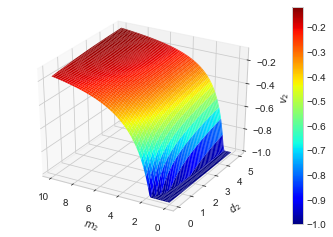

In [130]:
# a main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')

# a.1 constrain v2 values for plot purpose
limit_v2=np.array(np.copy(v2_grid))
limit_v2[limit_v2<(-1)]=-1

cs = ax.plot_surface(m2_grid,d2_grid,limit_v2,cmap=cm.jet)

# b. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d_2$')
ax.set_zlabel('$v_2$')

# c. invert xaxis
ax.invert_xaxis()

# d. add colorbar
fig.colorbar(cs);

The figuere shows that a high $m_{2}$ yields a high $v_{2}$, because higher cash at hand in the beggining of period two, implies better consumption possibilities and thereby higher utility. Furthermore, a higher $d$ implies a higher $v_{2}$, because a higher stack of durable consumption goods in period 1 gives a higher utility in period 2

For $c^{\ast}(m_2,d)$:

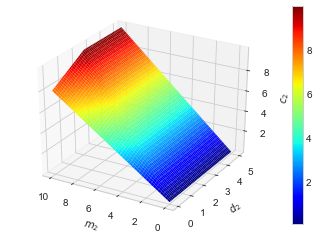

In [132]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d2_grid,c2_grid,cmap=cm.jet)

# b. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d_2$')
ax.set_zlabel('$c_2$')

# c. invert xaxis
ax.invert_xaxis()

# d. add colorbar
fig.colorbar(cs);

The firgure shows that a high $m_{2}$ yields a high $c^{\ast}$, because more cash at hand in the beginning of period 2 implies higher comsumption in period 2.

For $x^{\ast}(m_2,d)$:

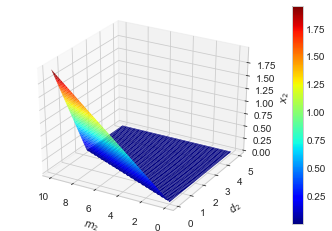

In [133]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')

cs = ax.plot_surface(m2_grid,d2_grid,x2_grid,cmap=cm.jet)

# b. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d_2$')
ax.set_zlabel('$x_2$')

# c. invert xaxis
ax.invert_xaxis()

# d. add colorbar
fig.colorbar(cs);

$m_2$ has a positive effect on $x^{\ast}$, which is clear from the definition of $x^{\ast}$. $d$ has an indirect positive effect through $m_2$, because it affects $a$ positively, which affects $m_2$ positively. 

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

In [134]:
# a. define solve function
def solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-8,10,100)
    v1_vec = np.empty(100)
    #c1_vec = np.empty(100)
    d2_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],m1,alpha,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess
        x0 = [m1*1/3, m1*1/3]
        
        # iii. bounds and constraitns
        bound = (1e-9,m1-1e-9)
        bounds = (bound, bound)
        ineq_con = {'type': 'ineq', 'fun': lambda x: m1-x[0]} 
        
        # iv. optimize
        result = optimize.minimize(obj,x0, method='SLSQP',
                                   bounds=bounds,
                                   constraints=[ineq_con])
        
        #result = optimize.minimize(obj,x0, method='Nelder-Mead')
        
        # v. save
        v1_vec[i] = -result.fun
        d2_vec[i] = result.x[0]
     
    return m1_vec,v1_vec,d2_vec

# b. construct interpolator
v2_interp = interpolate.RegularGridInterpolator((m2_vec,d2_vec), v2_grid,
                                                bounds_error=False,fill_value=None)
    
# c. solve period 1
m1_vec,v1_vec,d2_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp)

# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,v1_vec,label='v1 utility')
ax.plot(m1_vec,d2_vec,label='durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_xlim([0,11])
ax.set_ylim([-2.5,2.5]);

ValueError: The points in dimension 1 must be strictly ascending

durable consumption is increasing linearily in m1 with a coefficient of (1-alpha), which comes from the Cobb-Douglas utility function.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [135]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.